In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from scipy.spatial import distance
from sklearn.ensemble import IsolationForest



warnings.filterwarnings('ignore')

### Description of Data:
For our data sets we used data from basketball-reference.com to get a list of the 75th anniversary team as well as the last three seasons for all NBA players. While the 75th anniversary team already came in a career format, to get a list of the players under 25 we took the last three seasons, and filtered it to include weighted averages (by games played) for all stats that appear in the 75th anniversary team data. So now, we have a list of the career stats from 75th anniversary team compared with the stats of all players under 25 in the past 3 seasons. We took the last 3 seasons to analyze the top young players in the league because that gives a good metric of where these players will be headed in their career. If we go back too far, we run into problems like players stats can be skewed by low numbers in their early career.

In [2]:
data75=pd.read_csv('../data/75thTeam.csv')
data75['Player'] = data75['Player'].str.replace(r'\\.*', '')
data75['WS/48'] = data75['WS/48'].str.replace(r'\\.*', '').astype('float')
data75 = data75.drop([76])

data2021=pd.read_csv('../data/2021.csv')
data2021Advanced=pd.read_csv('../data/2021A.csv')
data2020=pd.read_csv('../data/2020.csv')
data2020Advanced=pd.read_csv('../data/2020A.csv')
data2019=pd.read_csv('../data/2019.csv')
data2019Advanced=pd.read_csv('../data/2019A.csv')


under25 = data2021[data2021['Age']<=25]
under25['Player'] = under25['Player'].str.replace(r'\\.*', '')
under25['PTS'] = under25['PTS'].str.replace(r'\\.*', '').astype('float')
under25 = under25.join(data2021Advanced['WS'])
under25 = under25.join(data2021Advanced['WS/48'])
under25=under25.drop_duplicates(subset=['Player'])
under25.head(10)

data2020 = data2020.join(data2020Advanced['WS'])
data2020 = data2020.join(data2020Advanced['WS/48'])
data2020['Player'] = data2020['Player'].str.replace(r'\\.*', '')
data2020['PTS'] = data2020['PTS'].str.replace(r'\\.*', '').astype('float')
data2020=data2020.drop_duplicates(subset=['Player'])

data2019 = data2019.join(data2019Advanced['WS'])
data2019 = data2019.join(data2019Advanced['WS/48'])
data2019['Player'] = data2019['Player'].str.replace(r'\\.*', '')
data2019['PTS'] = data2019['PTS'].str.replace(r'\\.*', '').astype('float')
data2019=data2019.drop_duplicates(subset=['Player'])

under25players = under25["Player"].unique()

datasets = [data2020,data2019]

for i in range(len(datasets)):
    for index,row in datasets[i].iterrows():
        if(row["Player"] in under25players):
            WS = row["WS"]
            GP = row["G"]
            MP = row["MP"]
            PTS = row["PTS"]
            TRB = row["TRB"]
            AST = row["AST"]
            STL = row["STL"]
            BLK = row["BLK"]
            TPA = row["3PA"]
            TPP = row["3P%"]
            FGA = row["FGA"]
            FGP = row["FG%"]
            FTA = row["FTA"]
            FTP = row["FT%"]

            WS2 = under25[under25['Player']==row["Player"]]["WS"]
            GP2 = under25[under25['Player']==row["Player"]]["G"]
            MP2 = under25[under25['Player']==row["Player"]]["MP"]
            PTS2 = under25[under25['Player']==row["Player"]]["PTS"]
            TRB2 = under25[under25['Player']==row["Player"]]["TRB"]
            AST2 = under25[under25['Player']==row["Player"]]["AST"]
            STL2 = under25[under25['Player']==row["Player"]]["STL"]
            BLK2 = under25[under25['Player']==row["Player"]]["BLK"]
            TPA2 = under25[under25['Player']==row["Player"]]["3PA"]
            TPP2 = under25[under25['Player']==row["Player"]]["3P%"]
            FGA2 = under25[under25['Player']==row["Player"]]["FG"]
            FGP2 = under25[under25['Player']==row["Player"]]["FG%"]
            FTA2 = under25[under25['Player']==row["Player"]]["FT"]
            FTP2 = under25[under25['Player']==row["Player"]]["FT%"]

            #newWS48 = (((WS+WS2)/((GP*MP)+(GP2*MP2)))*48)
            #print(newWS48)
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'WS/48'] = (((WS+WS2)/((GP*MP)+(GP2*MP2)))*48)
            #print(PTS,GP,PTS2,GP2, ((PTS*GP)+(PTS2*GP2))/(GP+GP2))
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'PTS'] = ((PTS*GP)+(PTS2*GP2))/(GP+GP2)
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'MP'] = ((MP*GP)+(MP2*GP2))/(GP+GP2)
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'TRB'] = ((TRB*GP)+(TRB2*GP2))/(GP+GP2)
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'MP'] = ((MP*GP)+(MP2*GP2))/(GP+GP2)
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'AST'] = ((AST*GP)+(AST2*GP2))/(GP+GP2)
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'STL'] = ((STL*GP)+(STL2*GP2))/(GP+GP2)
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'BLK'] = ((BLK*GP)+(BLK2*GP2))/(GP+GP2)

            total_threes = TPA*GP*TPP
            total_threes2 = TPA2*GP2*TPP2
            TTM = total_threes + total_threes2
            newTPP = TTM / (TPA*GP+TPA2*GP2)

            total_fg = FGA*GP*FGP
            total_fg2 = FGA2*GP2*FGP2
            TFGM = total_fg + total_fg2
            newFGP = TFGM / (FGA*GP+FGA2*GP2)

            total_ft = FTA*GP*FTP
            total_ft2 = FTA2*GP2*FTP2
            TFTM = total_ft + total_ft2
            newFTP = TFTM / (FTA*GP+FTA2*GP2)

            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'3P%'] = newTPP
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'FG%'] = newFGP
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'FT%'] = newFTP

            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'3PA'] = ((TPA*GP)+(TPA2*GP2))/(GP+GP2)
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'FGA'] = ((FGA*GP)+(FGA2*GP2))/(GP+GP2)
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'FTA'] = ((FTA*GP)+(FTA2*GP2))/(GP+GP2)
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'WS'] = WS + WS2
            under25.at[under25.index[under25['Player'] == row["Player"]].tolist()[0],'G'] = GP + GP2

under25= under25[under25['MP']>=8]
under25= under25[under25['G']>=5]

In [3]:
top5WS = under25.nlargest(5, ['WS'])
top5WS

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,WS,WS/48
343,262,Nikola Joki,C,25.0,DEN,225.0,72.0,32.583111,10.2,11.942222,...,8.0,10.443111,7.522667,1.303111,0.667556,3.1,2.7,22.051111,37.2,0.243562
3,4,Bam Adebayo,C,23.0,MIA,218.0,64.0,29.696330,7.1,6.648624,...,6.7,8.756881,4.097248,1.054128,1.023853,2.6,2.3,14.088991,24.1,0.178689
10,9,Jarrett Allen,C,22.0,TOT,213.0,45.0,27.304225,4.7,5.601408,...,6.9,9.267606,1.554460,0.532864,1.404695,1.6,1.5,11.527700,22.2,0.183225
577,444,Domantas Sabonis,PF,24.0,IND,198.0,62.0,31.438384,7.8,8.435354,...,9.5,11.116162,4.747475,0.850505,0.462626,3.4,3.3,17.419192,22.0,0.169644
171,130,Luka Don,PG,21.0,DAL,199.0,66.0,33.325628,9.8,12.224121,...,7.2,8.356784,7.720603,1.036181,0.335678,4.3,2.3,25.685427,21.4,0.154890


We have printed out the top 10 players with the highest win shares. We used win shares instead of win shares per 48 as total win shares gives at least some indicator of volume of games played. This is a good preliminary indicator of some of the players that we might see being among the legends after our full analysis. Some of the players we hypothesized would be in that category appear here: Nikola Jokic, Luka Doncic, Jayson Tatum. Some other players like Karl-Anthony Towns and Domantas Sabonis also appear here and they are some of the best young players in the leauge.

In [4]:
print(under25["WS"].mean())

4.280722891566265


Also printing out the average value in the win shares column can give us an idea of how large this statistic is for the top 5 players 

In [5]:
top575WS = data75.nlargest(5, ['WS'])
top575WS

,Player,From,To,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,Kareem Abdul-Jabbar,1970.0,1989.0,1560.0,36.8,24.6,11.2,3.6,0.9,2.6,0.559,0.056,0.721,273.4,0.228
12,Wilt Chamberlain,1960.0,1973.0,1045.0,45.8,30.1,22.9,4.4,NaN,NaN,0.540,NaN,0.511,247.3,0.248
32,LeBron James,2004.0,2022.0,1316.0,38.2,27.0,7.4,7.4,1.6,0.8,0.504,0.345,0.734,242.6,0.232
40,Karl Malone,1986.0,2004.0,1476.0,37.2,25.0,10.1,3.6,1.4,0.8,0.516,0.274,0.742,234.6,0.205
35,Michael Jordan,1985.0,2003.0,1072.0,38.3,30.1,6.2,5.3,2.3,0.8,0.497,0.327,0.835,214.0,0.250


In [6]:
def mahalanobis(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()
under25.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'WS',
       'WS/48'],
      dtype='object')

In [7]:
under25_triple_df = under25[['PTS', 'AST', 'TRB']].copy()
top75_triple_df = data75[['PTS', 'AST', 'TRB']].copy()
#print(top75_triple_df.isna().values.any())

i_forest_u25 = IsolationForest().fit(under25_triple_df)
i_forest_t75 = IsolationForest().fit(top75_triple_df)

#calculate mahalanobis distance for triple stats (PTS,AST,REB)
under25_triple_df['mahalanobis'] = mahalanobis(x=under25_triple_df, data=under25[['PTS', 'AST', 'TRB']])
top75_triple_df['mahalanobis'] = mahalanobis(x=top75_triple_df, data=top75_triple_df[['PTS', 'AST', 'TRB']])
#print(top75_triple_df)

#calculate i-forest score for triple states (PTS,AST,REB)
under25_triple_df['forest_score']=i_forest_u25.decision_function(under25_triple_df[['PTS','AST','TRB']])
top75_triple_df['forest_score']=i_forest_t75.decision_function(top75_triple_df[['PTS','AST','TRB']])

top75_triple_df['Player'] = data75['Player']
under25_triple_df['Player'] = under25['Player']

print("Under 25 Players:")
print("Top Outliers By Mahalanobis:")
print(under25_triple_df.nsmallest(5,['forest_score']),'\n')
print("Top Outliers By Iso Forest:")
print(under25_triple_df.nlargest(5,['mahalanobis']), '\n')

print("Top 75 Players:")
print("Top Outliers By Mahalanobis:")
print(top75_triple_df.nsmallest(5,['forest_score']), '\n')
print("Top Outliers By Iso Forest:")
print(top75_triple_df.nlargest(5,['mahalanobis']))

Under 25 Players:
Top Outliers By Mahalanobis:
           PTS       AST        TRB  mahalanobis  forest_score  \
702  24.102941  8.854412   3.938235    22.132027     -0.205873   
638  24.977160  3.955556  11.498765    16.028920     -0.195092   
343  22.051111  7.522667  10.443111    22.343972     -0.182220   
171  25.685427  7.720603   8.356784    15.629486     -0.168755   
577  17.419192  4.747475  11.116162    18.000146     -0.152265   

                 Player  
702          Trae Young  
638  Karl-Anthony Towns  
343         Nikola Joki  
171            Luka Don  
577    Domantas Sabonis   

Top Outliers By Iso Forest:
           PTS       AST        TRB  mahalanobis  forest_score  \
592  15.975773  7.548969   8.027835    23.437396     -0.131784   
343  22.051111  7.522667  10.443111    22.343972     -0.182220   
702  24.102941  8.854412   3.938235    22.132027     -0.205873   
577  17.419192  4.747475  11.116162    18.000146     -0.152265   
71   26.266667  5.862189   4.168159    1

In the above code I calculated outliers of the under 25 players and top 75 players using mahalanobis distance and isolation forest strategies for the (overused) triple of PTS,AST,REB. These players are standout offensive players. Now, in order to get a feel of how the outliers for the under 25 players compare to the top 75 players I'm going to plot an offensive volume metric (PTS+AST+REB) vs minutes played.

In [8]:
under25_all_stats = under25.copy()
under25_all_stats = under25_all_stats.drop(labels=['Rk','Player','Pos','Age','Tm','GS','FG','FGA','3P','3PA'
                                                   ,'2P','2PA','FT','FTA','ORB','DRB','PF','G','eFG%','TOV','2P%'],axis=1)
under25_all_stats = under25_all_stats.fillna(value=under25_all_stats['3P%'].mean())

under25_all_stats_mala = under25_all_stats.copy()
under25_all_stats_iso = under25_all_stats.copy()
under25_all_stats_mala['mahalanobis'] = mahalanobis(x=under25_all_stats_mala, data=under25_all_stats_mala[under25_all_stats_mala.columns])
under25_all_stats_mala["Player"] = under25["Player"]
top10= under25_all_stats_mala.nlargest(10, ['mahalanobis'])
print(top10)

clf = IsolationForest().fit(under25_all_stats_iso)
under25_all_stats_iso["IsolationForest"] = clf.decision_function(under25_all_stats_iso[under25_all_stats_iso.columns])
under25_all_stats_iso["Player"] = under25["Player"]

top10Iso= under25_all_stats_iso.nsmallest(10, ['IsolationForest'])
print(top10Iso)

            MP       FG%       3P%       FT%        TRB       AST       STL  \
646  29.521311  0.477534  0.354205  0.751580   6.816940  1.310383  0.791803   
343  32.583111  0.528856  0.334492  0.836494  10.443111  7.522667  1.303111   
532  31.413000  0.439693  0.361344  0.815209   9.242000  1.714000  0.614000   
702  33.058824  0.426290  0.343706  0.859004   3.938235  8.854412  0.927941   
280  25.800000  0.353000  0.278000  0.824000   2.700000  5.300000  1.000000   
631  19.900000  0.422158  0.330217  0.586286   1.750000  1.100000  1.500000   
565  22.918987  0.707830  0.319272  0.584552   6.965190  0.580380  0.897468   
577  31.438384  0.559995  0.314894  0.722537  11.116162  4.747475  0.850505   
592  34.014433  0.566739  0.202786  0.608066   8.027835  7.548969  1.665464   
171  33.325628  0.448201  0.331137  0.732864   8.356784  7.720603  1.036181   

          BLK        PTS    WS     WS/48  mahalanobis             Player  
646  2.676503  12.713661  13.8  0.122612    57.678088  

For this set of outliers, we took all columns that overlapped between legends and players under 25 and dropped any columns that weren't in both. This way, we can use a standard for players under 25 that is the same standard for those on the 75th team. 

Looking at the data above, we can see some obvious candidates for best players under 25, including Nikola Jokic, Karl-Anthony Towns, and Trae Young. (We won't talk about Ben Simmons.) These players are easily some of the best players of their generation, and the stats prove this. But these lists also include mostly unknown players, due to their stats being outliers in the wrong direction. One example on both the Mahalanobis and Isolation Forest lists is Karim Man, who is an outlier with a negative WS and WS/48, and only averaging 1.1 PTS per game. 

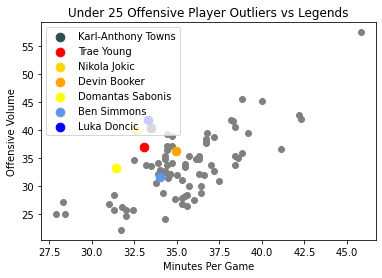

In [9]:
y = data75['PTS']+data75['AST']+data75['TRB']
x = data75['MP']

KAT = under25[under25['Player'].isin(['Karl-Anthony Towns'])]
Trae = under25[under25['Player'].isin(['Trae Young'])]
Nikola = under25[under25['Player'].isin(['Nikola Joki'])]
Devin = under25[under25['Player'].isin(['Devin Booker'])]
Sabonis = under25[under25['Player'].isin(['Domantas Sabonis'])]
Simmons = under25[under25['Player'].isin(['Ben Simmons'])]
Luka = under25[under25['Player'].isin(['Luka Don'])]

x1 = KAT['MP']
x2 = KAT['PTS']+KAT['AST']+KAT['TRB']

x3 = Trae['MP']
x4 = Trae['PTS']+Trae['AST']+Trae['TRB']\

x5 = Nikola['MP']
x6 = Nikola['PTS']+Nikola['AST']+Nikola['TRB']

x7 = Devin['MP']
x8 = Devin['PTS']+Devin['AST']+Devin['TRB']

x9 = Sabonis['MP']
x10 = Sabonis['PTS']+Sabonis['AST']+Sabonis['TRB']

x11 = Simmons['MP']
x12 = Simmons['PTS']+Simmons['AST']+Simmons['TRB']

x13 = Luka['MP']
x14 = Luka['PTS']+Luka['AST']+Luka['TRB']

plt.scatter(x,y,color='grey')
plt.scatter(x1,x2,color = 'darkslategrey', s=75,label = 'Karl-Anthony Towns')
plt.scatter(x3,x4,color = 'red', s=75,label = 'Trae Young')
plt.scatter(x5,x6,color = 'gold', s=75,label = 'Nikola Jokic')
plt.scatter(x7,x8,color = 'orange', s=75,label = 'Devin Booker')
plt.scatter(x9,x10,color = 'yellow', s=75,label = 'Domantas Sabonis')
plt.scatter(x11,x12,color = 'cornflowerblue', s=75,label = 'Ben Simmons')
plt.scatter(x13,x14,color = 'blue', s=75,label = 'Luka Doncic')
plt.xlabel("Minutes Per Game")
plt.ylabel("Offensive Volume")
plt.title("Under 25 Offensive Player Outliers vs Legends")
plt.legend()

In [10]:
under25_defense_df = under25[['STL', 'BLK']].copy()
top75_defense_df = data75[['STL', 'BLK']].copy()
#print(top75_triple_df.isna().values.any())
top75_defense_df.dropna()

i_forest_u25 = IsolationForest().fit(under25_defense_df)
#i_forest_t75 = IsolationForest().fit(top75_defense_df)

#calculate mahalanobis distance for triple stats (PTS,AST,REB)
under25_defense_df['mahalanobis'] = mahalanobis(x=under25_defense_df, data=under25[['STL', 'BLK']])
#top75_defense_df['mahalanobis'] = mahalanobis(x=top75_defense_df, data=top75_defense_df[['STL', 'BLK']])
#print(top75_triple_df)

#calculate i-forest score for triple states (PTS,AST,REB)
under25_defense_df['forest_score']=i_forest_u25.decision_function(under25_defense_df[['STL', 'BLK']])
#top75_defense_df['forest_score']=i_forest_t75.decision_function(top75_defense_df[['STL', 'BLK']])

#top75_defense_df['Player'] = data75['Player']
under25_defense_df['Player'] = under25['Player']

print("Under 25 Players:")
print("Top Outliers By Mahalanobis:")
print(under25_defense_df.nsmallest(5,['forest_score']),'\n')
print("Top Outliers By Iso Forest:")
print(under25_defense_df.nlargest(5,['mahalanobis']), '\n')


Under 25 Players:
Top Outliers By Mahalanobis:
          STL       BLK  mahalanobis  forest_score             Player
646  0.791803  2.676503    36.991082     -0.256223       Myles Turner
565  0.897468  2.068987    19.609919     -0.205833  Mitchell Robinson
592  1.665464  0.681443    11.031290     -0.161414        Ben Simmons
463  1.599248  0.199248    10.938118     -0.146142    Dejounte Murray
631  1.500000  0.900000     8.455868     -0.143859   Matisse Thybulle 

Top Outliers By Iso Forest:
          STL       BLK  mahalanobis  forest_score             Player
646  0.791803  2.676503    36.991082     -0.256223       Myles Turner
565  0.897468  2.068987    19.609919     -0.205833  Mitchell Robinson
532  0.614000  1.699000    12.178655     -0.105550     Kristaps Porzi
592  1.665464  0.681443    11.031290     -0.161414        Ben Simmons
463  1.599248  0.199248    10.938118     -0.146142    Dejounte Murray 



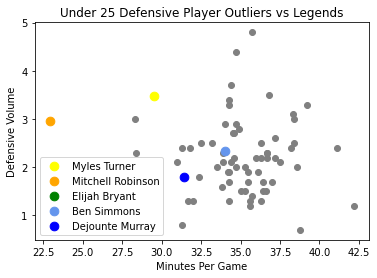

In [11]:
y = data75['BLK']+data75['STL']
x = data75['MP']

Myles = under25[under25['Player'].isin(['Myles Turner'])]
Mitchell = under25[under25['Player'].isin(['Mitchell Robinson'])]
Elijah = under25[under25['Player'].isin(['Elijah Bryant'])]
Ben = under25[under25['Player'].isin(['Ben Simmons'])]
Dejounte = under25[under25['Player'].isin(['Dejounte Murray'])]

x1 = Myles['MP']
x2 = Myles['BLK']+Myles['STL']

x3 = Mitchell['MP']
x4 = Mitchell['BLK']+Mitchell['STL']

x5 = Elijah['MP']
x6 = Elijah['BLK']+Elijah['STL']

x7 = Ben['MP']
x8 = Ben['BLK']+Ben['STL']

x9 = Sabonis['MP']
x10 = Dejounte['BLK']+Dejounte['STL']


plt.scatter(x,y,color='grey')
plt.scatter(x1,x2,color = 'yellow', s=75,label = 'Myles Turner')
plt.scatter(x3,x4,color = 'orange', s=75,label = 'Mitchell Robinson')
plt.scatter(x5,x6,color = 'green', s=75,label = 'Elijah Bryant')
plt.scatter(x7,x8,color = 'cornflowerblue', s=75,label = 'Ben Simmons')
plt.scatter(x9,x10,color = 'blue', s=75,label = 'Dejounte Murray')

plt.xlabel("Minutes Per Game")
plt.ylabel("Defensive Volume")
plt.title("Under 25 Defensive Player Outliers vs Legends")
plt.legend()

The outliers using all available stats for the under 25 player pool produced worse overall players compared to the triple stat of PTS, AST, REB. This makes sense because bad players are also outliers as well. The PTS, AST, REB triple league averages are going to be relatively low, therefore outliers will most likely be high numbers, thus good players. However, once we start including more convoluted stats like field goal percentage and win shares, bad players will be outliers in a number of these metrics and therefore they will overshadow some better players. 

We created two plots on Offensive Volume and Defensive Volume to see initial estimates of where we thought players under 25 would stack up against the 75th Team.

**What's missing??**
So far, we have a good idea of good players who are outliers just in a statistic for offensive load and defensive load separately, and we have outliers in all stats that include bad players that definitely won't be amoung the legends. We need to find a better benchmark to compare current players to the all time greats that include some idea of offense, defense and efficiency concurrently.

### UV Decomposition:

It's going to be hard to use any other data science methods with unknown values within our dataset.

**1) pre-processing**

In [12]:
data75_raw = data75.drop(columns = ['Player','From','To','G'])
M = data75_raw.to_numpy()
# initialize
player_means = np.zeros(M.shape[0])
stat_means = np.zeros(M.shape[1])

#amount subtracted from original M
M_sub = np.zeros(M.shape)

# TODO -- compute the mean stat for each user (not including blanks)
player_means = np.nanmean(M, axis=1)
#print(len(player_means))

# normalize M first by subtracting from each non-blank element that user's mean rating
M_norm = M.copy()
for u in range(len(player_means)):
    M_norm[u,:] -= player_means[u]
    M_sub[u,:] -= player_means[u]

# TODO -- compute the mean rating for each user (not including blanks)
stat_means = np.nanmean(M_norm, axis=0)
#print(len(stat_means))

# normalize M once more by subtracting from each non-blank element that item's mean rating
for i in range(len(stat_means)):
    M_norm[:,i] -= stat_means[i]
    M_sub[:,i] -= stat_means[i]
    
#print(M == M_norm-M_sub)
#print(M[:5])
#print((M_norm-M_sub)[:5])

Compute U and V

In [13]:
def RMSE(M1, M2):
    rmse=np.sqrt(np.nansum((M1-M2)**2)/(M1.shape[0]*M1.shape[1]-np.sum(np.isnan(M1))))
    return rmse

In [14]:
##Now set it up as a loop, running down U and V in order (by whichever dimension first)
d=5
U = np.ones((M.shape[0],d))
V= np.ones((d,M.shape[1]))

error = 100
while(error>0.75):
    for r in range(M.shape[0]):
        for s in range(d):
            U[r,s]=np.nansum([V[s,j]*(M_norm[r,j]-np.sum(U[r,:]*V[:,j])+U[r,s]*V[s,j])  for j in range(M.shape[1])])/np.nansum(V[s,:]**2)
    for s in range(M.shape[1]):
        for r in range(d):
            V[r,s]=np.nansum([U[i,r]*(M_norm[i,s]-np.sum(U[i,:]*V[:,s])+U[i,r]*V[r,s])  for i in range(M.shape[0])])/np.nansum(U[:,r]**2)

    #print(U)
    #print(V)

    P=np.matmul(U,V)

    #Put M_sub into P
    P_unnorm= P-M_sub
    error = RMSE(M,P_unnorm)
    
print(error)

0.7483431053506279


In [15]:
UV_df = pd.DataFrame(P_unnorm, columns = data75_raw.columns)
UV_df['Player'] = data75['Player']

In [16]:
UV_df[UV_df['Player']=='Bob Pettit']

,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Player
55,40.117016,25.846508,15.762474,2.790975,8.737596,8.693741,0.595272,7.691772,0.859576,135.938818,0.341378,Bob Pettit


In [17]:
UV_df[UV_df['Player']=='Wilt Chamberlain']

,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Player
12,48.234176,29.090925,23.0634,4.839509,15.684264,15.124947,0.461624,16.265339,0.630531,246.588807,0.259209,Wilt Chamberlain


In [18]:
UV_df[UV_df['Player']=='Elgin Baylor']

,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Player
8,39.553564,27.099878,12.987232,3.559363,7.589829,7.309928,0.94197,6.294423,1.262477,104.435723,0.681469,Elgin Baylor


The UV decomposition did a really good job giving us U and V matrices with a low RMSE value, however, for the originally unknown values, the UV decomposition gave us impossibly high numbers. For example, as great as Wilt Chamberlain was, he did not average 15 steals and blocks per game. Also, the 3P% column is definitely not a percentage. Because of this it is important to normalize the unknown statistics based off of known values. For example, some researchers have found that Wilt Chamberlain averaged around 8.8 blocks per game. In order to fix the unknown values we got from UV decomposition, every unknown value will be multiplied by the ratio of Wilts' (8.8/15.1) blocks to give us a more realistic number for comparison. Similarly, steals will be multiplied by 2.1/15.68.

In [19]:
block_bench = 8.8/15.1
stl_bench = 2.1/15.68
tp_total = 0
data75_complete = data75.copy()
for player in list(data75['Player']):
    for stat in data75.columns:
        if(data75.loc[data75[data75['Player']==player].index][stat].isnull().any()):
            if(stat == 'STL'):
                data75_complete.at[data75_complete.index[data75_complete['Player'] == player].tolist()[0],stat] = stl_bench*UV_df[UV_df['Player']==player][stat].tolist()[0]
                #data75.loc[data75[data75['Player']==player].index][stat] = 0#stl_bench*UV_df[UV_df['Player']==player][stat]
            if(stat == 'BLK'):
                data75_complete.at[data75_complete.index[data75_complete['Player'] == player].tolist()[0],stat] = block_bench*UV_df[UV_df['Player']==player][stat].tolist()[0]
            if(stat == '3P%'):
                if(UV_df[UV_df['Player']==player][stat].tolist()[0]>0.6):
                    tp_total += UV_df[UV_df['Player']==player][stat].tolist()[0]
                #print(tp_total)
                
for player in list(data75['Player']):
    for stat in data75.columns:
        if(data75.loc[data75[data75['Player']==player].index][stat].isnull().any()):
            if(stat == '3P%'):
                #if(UV_df[UV_df['Player']==player][stat].tolist()[0]>0.6):
                    data75_complete.at[data75_complete.index[data75_complete['Player'] == player].tolist()[0],stat] = UV_df[UV_df['Player']==player][stat].tolist()[0]/tp_total

In [20]:
data75_complete[data75_complete['Player']=='Dave Bing']

,Player,From,To,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
9,Dave Bing,1967.0,1978.0,901.0,36.4,20.3,3.8,6.0,1.3,0.2,0.441,0.002581,0.775,68.8,0.101


I have updated our original data frame with the UV estimated values for missing statistics. The 3P% column was tricky because the UV decomposition was giving me values that were >1. In order to accommodate for this I divided the values that were >1 by the total sum of all estimated 3P%. Why does this make sense? UV decomposition has a sense of players' role and outlierness. This is because it very closely estimates the other known statistics so although it's estimated statistics might be off, they give a relatively good idea of the outlierness of a players value in that statistical column. If I divide each value estimated value for 3P% by the total estimated sum for 3P%, the proportion of outlierness will be preserved.

Although the resulting values estimated from UV decomposition aren't necessarily correct they give a good proportional idea of a players' role and outlierness. When comparing players if we can maintain this sense then the comparison will still be valid. 

### K-means:

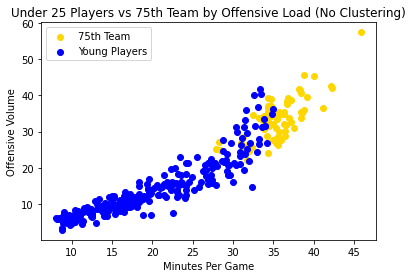

In [21]:
y75 = data75['PTS']+data75['AST']+data75['TRB']
x75 = data75['MP']

y25 = under25_all_stats['PTS']+under25_all_stats['AST']+under25_all_stats['TRB']
x25 = under25_all_stats['MP']

plt.scatter(x75,y75,color='gold',label = "75th Team")
plt.scatter(x25,y25,color='blue',label = "Young Players")
plt.xlabel("Minutes Per Game")
plt.ylabel("Offensive Volume")
plt.title("Under 25 Players vs 75th Team by Offensive Load (No Clustering)")
plt.legend()

This is a similar plot to the one above. The is offensive load by minutes per game colored by under 25 players and legends. We wanted to get a good baseline of where all players laid on a simple axis before clustering. But, offensive load only takes into account 3 statistics (PTS, TRB, AST), and we are going to be clustering based on 10 total columns or dimensions.

In [22]:
AllPlayers = under25_all_stats.copy()
AllPlayers = AllPlayers.drop(labels='WS',axis=1)
AllPlayers["Player"] = under25["Player"]
data75copy = data75_complete.copy()
data75copy=data75copy.drop(labels=['WS','From','To','G'],axis=1)

data75copy.drop(labels=['Player','PTS','3P%','FG%','FT%'], axis=1,inplace = True)
data75copy.insert(6, 'Player', data75['Player'])
data75copy.insert(5, 'PTS', data75_complete['PTS'])
data75copy.insert(1, 'FG%', data75_complete['FG%'])
data75copy.insert(2, '3P%', data75_complete['3P%'])
data75copy.insert(3, 'FT%', data75_complete['FT%'])

AllPlayers = pd.concat([AllPlayers,data75copy])
print(AllPlayers.columns)

Index(['MP', 'FG%', '3P%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'PTS', 'WS/48',
       'Player'],
      dtype='object')


After reducing the under 25 players to match the exact columns of the 75th team, we were left with 11 total columns on which to compare. We ended up dropping Win Shares due to redundancy with WS/48 and because the stat is a result of time spent in the league, we figured WS/48 was a more fair comparison for young players. We were then left with 10 columns on which to cluster as seen above. There are a total of 249 candidate young players and 76 total players on the 75th Team, for a total of 350 players we're comparing. 

In [23]:
data = AllPlayers.to_numpy()
#randpoints = np.random.randint(len(data),size=2)
centroid0 = data[261].copy()
centroid1 = data[1].copy()
allCentroids = [centroid0,centroid1]
numIterations = 100
clusterIdx = []

for z in range(0,numIterations):
    clusterIdx = []
    for i in data: #Assigning each point to cluster
        Idx = 0
        lowestDist = np.Inf
        dist0 = distance.euclidean([i[0],i[1],i[2],i[3],i[4],i[5],i[6],i[7],i[8],i[9]],
                                   [allCentroids[0][0],allCentroids[0][1],allCentroids[0][2],allCentroids[0][3],allCentroids[0][4],
                                   allCentroids[0][5],allCentroids[0][6],allCentroids[0][7],allCentroids[0][8],allCentroids[0][9]])
        dist1 = distance.euclidean([i[0],i[1],i[2],i[3],i[4],i[5],i[6],i[7],i[8],i[9]],
                                   [allCentroids[1][0],allCentroids[1][1],allCentroids[1][2],allCentroids[1][3],allCentroids[1][4],
                                   allCentroids[1][5],allCentroids[1][6],allCentroids[1][7],allCentroids[1][8],allCentroids[1][9]])
        if(dist0 < lowestDist):
            lowestDist = dist0
            Idx = 0
        if(dist1 < lowestDist):
            lowestDist = dist1
            Idx = 1
        clusterIdx += [Idx]


    for j in range(0,2): #Updating each centroid
        Coords0,Coords1,Coords2,Coords3,Coords4,Coords5,Coords6,Coords7,Coords8,Coords9 = [],[],[],[],[],[],[],[],[],[]
        for i in range(0,len(data)):
            if clusterIdx[i] == j:
                Coords0.append(data[i][0])
                Coords1.append(data[i][1])
                Coords2.append(data[i][2])
                Coords3.append(data[i][3])
                Coords4.append(data[i][4])
                Coords5.append(data[i][5])
                Coords6.append(data[i][6])
                Coords7.append(data[i][7])
                Coords8.append(data[i][8])
                Coords9.append(data[i][9])
        numPoints = np.sum([clusterIdx[k]==j for k in range(len(clusterIdx))])
        allCentroids[j] = [np.sum(Coords0)/numPoints, np.sum(Coords1)/numPoints, np.sum(Coords2)/numPoints, np.sum(Coords4)/numPoints,
                          np.sum(Coords4)/numPoints,np.sum(Coords5)/numPoints,np.sum(Coords6)/numPoints,np.sum(Coords7)/numPoints,
                          np.sum(Coords8)/numPoints,np.sum(Coords9)/numPoints]

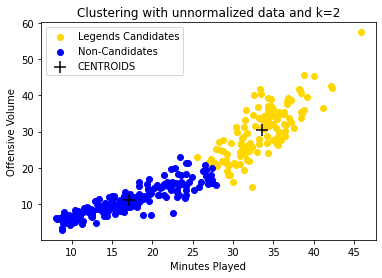

In [24]:
cluster0x,cluster0y,cluster1x,cluster1y,centroidsx,centroidsy = [],[],[],[],[],[]
centroidsx += [allCentroids[0][0],allCentroids[1][0]]
centroidsy += [(allCentroids[0][8]+allCentroids[0][4]+allCentroids[0][5]),(allCentroids[1][8]+allCentroids[1][4]+allCentroids[1][5])]
for i in range(0,len(clusterIdx)):
    if clusterIdx[i] == 0:
        cluster0x += [data[i][0]]
        cluster0y += [(data[i][8]+data[i][4]+data[i][5])]
    if clusterIdx[i] == 1:
        cluster1x += [data[i][0]]
        cluster1y += [(data[i][8]+data[i][4]+data[i][5])]
plt.scatter(cluster0x,cluster0y,color='gold',label="Legends Candidates")
plt.scatter(cluster1x,cluster1y,color='blue',label="Non-Candidates")
plt.scatter(centroidsx,centroidsy,color='black',label="CENTROIDS",s=150,marker='+')
plt.xlabel('Minutes Played')
plt.ylabel('Offensive Volume')
plt.title("Clustering with unnormalized data and k=2")
plt.legend()

In [25]:
Legends = pd.DataFrame()
LegendsUnder25 = pd.DataFrame()
for i in range(len(clusterIdx)):
    if(clusterIdx[i] == 0):
        Legends = pd.concat([Legends, pd.DataFrame([AllPlayers.iloc[i]])], ignore_index=True)
        if(i <= len(under25_all_stats)):
            LegendsUnder25 = pd.concat([LegendsUnder25, pd.DataFrame([AllPlayers.iloc[i]])], ignore_index=True)
print(len(LegendsUnder25),len(Legends))

54 129


### Clustering # 1 Results
After our first instance of clustering with k = 2, the legends candidates cluster contained 129 people, with 54 being current players under 25 and 75 players being from the 75th team. This is close to what we want, as our goal is to create a cluster that contains as many 75th team legends as possible while including as few under 25 players as possible to get a concise list. Since 54 under 25 players is a larger list than we'd like, our goal is to increase the number of clusters to create one optimal cluster that contains the best of the best.

Additionally, although we are using 10 separate columns for comparison, the weights of each columns are not being weighted how we like. For example, the range of WS/48 is only .376, while the range of Minutes Played is 37.6. Thus, with our current dataset, Minutes played is 100x more impactful for distance because the range is much larger, even though it is not a stat that demonstrates any kind of performance or skill.

In [26]:
print(min(AllPlayers['WS/48']),max(AllPlayers['WS/48']))
print(min(AllPlayers['MP']),max(AllPlayers['MP']))

-0.126 0.25
8.1 45.8


Thus, we looked at the ranges of all 10 stats and changed the weights of columns to make more important stats more impactful. We decided WS/48 should be much, much more impactful because it is a very telling advanced stat, MP, should be reduced because it does not depict skill, shooting stats should be increased because they show efficiency and currently only range from 0-1, and BLK and STL should be slightly increased because these stats are rare but show skillfulness defensively, which is an important aspect. 

In [27]:
AllPlayersAdjusted = AllPlayers.copy()
AllPlayersAdjusted['WS/48'] = 100 * AllPlayersAdjusted['WS/48']
AllPlayersAdjusted['MP'] = .5 * AllPlayersAdjusted['MP']
AllPlayersAdjusted['FG%'] = 10 * AllPlayersAdjusted['FG%']
AllPlayersAdjusted['3P%'] = 10 * AllPlayersAdjusted['3P%']
AllPlayersAdjusted['FT%'] = 10 * AllPlayersAdjusted['FT%']
AllPlayersAdjusted['STL'] = 5 * AllPlayersAdjusted['STL']
AllPlayersAdjusted['BLK'] = 5 * AllPlayersAdjusted['BLK']

6 57


Text(0.5, 1.0, 'Clustering with weighted data and k=4')

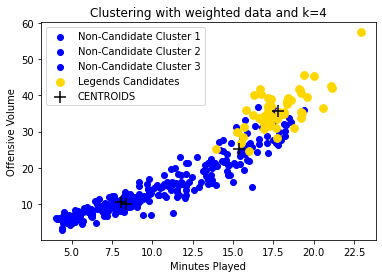

In [28]:
data = AllPlayersAdjusted.to_numpy()
#for xx in range(100):
randpoints = np.random.randint(len(data),size=4)
centroid0 = data[300].copy()#261
centroid1 = data[316].copy()#1
centroid2 = data[29].copy()#22
centroid3 = data[210].copy()
allCentroids = [centroid0,centroid1,centroid2,centroid3]
numIterations = 100
clusterIdx = []

for z in range(0,numIterations):
    clusterIdx = []
    for i in data: #Assigning each point to cluster
        Idx = 0
        lowestDist = np.Inf
        dist0 = distance.euclidean([i[0],i[1],i[2],i[3],i[4],i[5],i[6],i[7],i[8],i[9]],
                                   [allCentroids[0][0],allCentroids[0][1],allCentroids[0][2],allCentroids[0][3],allCentroids[0][4],
                                   allCentroids[0][5],allCentroids[0][6],allCentroids[0][7],allCentroids[0][8],allCentroids[0][9]])
        dist1 = distance.euclidean([i[0],i[1],i[2],i[3],i[4],i[5],i[6],i[7],i[8],i[9]],
                                   [allCentroids[1][0],allCentroids[1][1],allCentroids[1][2],allCentroids[1][3],allCentroids[1][4],
                                   allCentroids[1][5],allCentroids[1][6],allCentroids[1][7],allCentroids[1][8],allCentroids[1][9]])
        dist2 = distance.euclidean([i[0],i[1],i[2],i[3],i[4],i[5],i[6],i[7],i[8],i[9]],
                                   [allCentroids[2][0],allCentroids[2][1],allCentroids[2][2],allCentroids[2][3],allCentroids[2][4],
                                   allCentroids[2][5],allCentroids[2][6],allCentroids[2][7],allCentroids[2][8],allCentroids[2][9]])
        dist3 = distance.euclidean([i[0],i[1],i[2],i[3],i[4],i[5],i[6],i[7],i[8],i[9]],
                                   [allCentroids[3][0],allCentroids[3][1],allCentroids[3][2],allCentroids[3][3],allCentroids[3][4],
                                   allCentroids[3][5],allCentroids[3][6],allCentroids[3][7],allCentroids[3][8],allCentroids[3][9]])
        if(dist0 < lowestDist):
            lowestDist = dist0
            Idx = 0
        if(dist1 < lowestDist):
            lowestDist = dist1
            Idx = 1
        if(dist2 < lowestDist):
            lowestDist = dist2
            Idx = 2
        if(dist3 < lowestDist):
            lowestDist = dist3
            Idx = 3
        clusterIdx += [Idx]


    for j in range(0,4): #Updating each centroid
        Coords0,Coords1,Coords2,Coords3,Coords4,Coords5,Coords6,Coords7,Coords8,Coords9 = [],[],[],[],[],[],[],[],[],[]
        for i in range(0,len(data)):
            if clusterIdx[i] == j:
                Coords0.append(data[i][0])
                Coords1.append(data[i][1])
                Coords2.append(data[i][2])
                Coords3.append(data[i][3])
                Coords4.append(data[i][4])
                Coords5.append(data[i][5])
                Coords6.append(data[i][6])
                Coords7.append(data[i][7])
                Coords8.append(data[i][8])
                Coords9.append(data[i][9])
        numPoints = np.sum([clusterIdx[k]==j for k in range(len(clusterIdx))])
        allCentroids[j] = [np.sum(Coords0)/numPoints, np.sum(Coords1)/numPoints, np.sum(Coords2)/numPoints, np.sum(Coords4)/numPoints,
                          np.sum(Coords4)/numPoints,np.sum(Coords5)/numPoints,np.sum(Coords6)/numPoints,np.sum(Coords7)/numPoints,
                          np.sum(Coords8)/numPoints,np.sum(Coords9)/numPoints]


cluster0x,cluster0y,cluster1x,cluster1y,cluster2x,cluster2y,cluster3x,cluster3y,centroidsx,centroidsy = [],[],[],[],[],[],[],[],[],[]
centroidsx += [allCentroids[0][0],allCentroids[1][0],allCentroids[2][0],allCentroids[3][0]]
centroidsy += [(allCentroids[0][8]+allCentroids[0][4]+allCentroids[0][5]),(allCentroids[1][8]+allCentroids[1][4]+allCentroids[1][5]),
              (allCentroids[2][8]+allCentroids[2][4]+allCentroids[2][5]),(allCentroids[3][8]+allCentroids[3][4]+allCentroids[3][5]),]
for i in range(0,len(clusterIdx)):
    if clusterIdx[i] == 0:
        cluster0x += [data[i][0]]
        cluster0y += [(data[i][8]+data[i][4]+data[i][5])]
    if clusterIdx[i] == 1:
        cluster1x += [data[i][0]]
        cluster1y += [(data[i][8]+data[i][4]+data[i][5])]
    if clusterIdx[i] == 2:
        cluster2x += [data[i][0]]
        cluster2y += [(data[i][8]+data[i][4]+data[i][5])]
    if clusterIdx[i] == 3:
        cluster3x += [data[i][0]]
        cluster3y += [(data[i][8]+data[i][4]+data[i][5])]
plt.scatter(cluster1x,cluster1y,color='blue',label="Non-Candidate Cluster 1")
plt.scatter(cluster2x,cluster2y,color='blue',label="Non-Candidate Cluster 2")
plt.scatter(cluster3x,cluster3y,color='blue',label="Non-Candidate Cluster 3")
plt.scatter(cluster0x,cluster0y,color='gold',s=60,label="Legends Candidates")
plt.scatter(centroidsx,centroidsy,color='black',label="CENTROIDS",s=150,marker='+')
plt.legend()


clusterNum = clusterIdx[261]
Legends = pd.DataFrame()
LegendsUnder25 = pd.DataFrame()
for i in range(len(clusterIdx)):
    if(clusterIdx[i] == clusterNum):
        Legends = pd.concat([Legends, pd.DataFrame([AllPlayers.iloc[i]])], ignore_index=True)
        if(i < len(under25_all_stats)):
            LegendsUnder25 = pd.concat([LegendsUnder25, pd.DataFrame([AllPlayers.iloc[i]])], ignore_index=True)
print(len(LegendsUnder25),len(Legends))
plt.xlabel('Minutes Played')
plt.ylabel('Offensive Volume')
plt.title('Clustering with weighted data and k=4')

In [29]:
Legends = pd.DataFrame()
LegendsUnder25 = pd.DataFrame()
for i in range(len(clusterIdx)):
    if(clusterIdx[i] == 0):
        Legends = pd.concat([Legends, pd.DataFrame([AllPlayers.iloc[i]])], ignore_index=True)
        if(i < len(under25_all_stats)):
            LegendsUnder25 = pd.concat([LegendsUnder25, pd.DataFrame([AllPlayers.iloc[i]])], ignore_index=True)
print('Legend Candidates Under 25:',len(LegendsUnder25),'Total Players in Cluster:',len(Legends),'\n')
print(LegendsUnder25['Player'])

Legend Candidates Under 25: 6 Total Players in Cluster: 57 

0          John Collins
1              Luka Don
2           Nikola Joki
3        Kristaps Porzi
4    Karl-Anthony Towns
5       Zion Williamson
Name: Player, dtype: object


### Clustering # 2 Results

After changing our number of clusters from 2 to 4, and using our adjusted weighted stats, we can see that the Legend Candidate Cluster contained 57 total players with 6 of them being under 25. This is an ideal ratio, as our goal was to find a cluster with as many 75th Team players as possible while finding a small list of players under 25 who belong in this category. Thus, we are left with 6 players under 25, John Collins, Luka Dončić, Nikola Jokić, Kristaps Porziņģis, Karl-Anthony Towns, and Zion Williamson

A k value of 4 was much more appropriate, as this way we can get an upper cluster of just the best players our of both sets. The remaining 3 clusters have much less importance, and while we could likely rank these remaining clusters, they have no value for us. 


### Plotting The 6 Players

The above plots were all made using Offensive load vs Minutes Per Game. While these plots are useful to see basic clustering, they only use 4 out of the 10 columns to calculate the clusters. To better show how these 6 players stack up against players on the 75th team, we wanted to construct more plots using different axis.

In [30]:
labeled_legends = ['Wilt Chamberlain', 'Michael Jordan', 'LeBron James','Kareem Abdul-Jabbar','Magic Johnson']
colors = ['darkorange','black','blue','m','darkgreen']

Text(0, 0.5, 'Offensive volume')

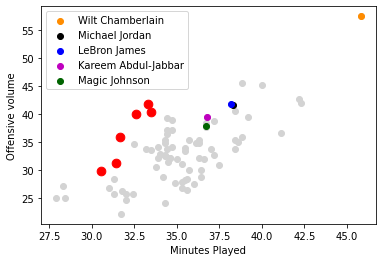

In [31]:
y75 = data75_complete['PTS']+data75_complete['AST']+data75_complete['TRB']
x75 = data75_complete['MP']
x25 = LegendsUnder25['MP']
y25 = LegendsUnder25['PTS']+LegendsUnder25['AST']+LegendsUnder25['TRB']


plt.scatter(x75,y75,c='lightgrey')
plt.scatter(x25,y25,s=75,c='red')

for i in range(len(labeled_legends)):
    player = labeled_legends[i]
    curr = data75_complete[data75_complete['Player']==player]
    plt.scatter(curr['MP'], curr['PTS']+curr['AST']+curr['TRB'], color = colors[i], label = player)
    

#plt.scatter(x75,y75,c='grey')
#plt.scatter(x25,y25,s=75,c='red')
plt.legend()
plt.xlabel('Minutes Played')
plt.ylabel('Offensive volume')

Here and the following plots are the top 6 young NBA players we found vs all legends (and well known legends are colorized). The plot above is offensive volume vs minutes played. Offensive volume is calculated as (PTS+AST+TRB)

Text(0, 0.5, 'Defensive Volume')

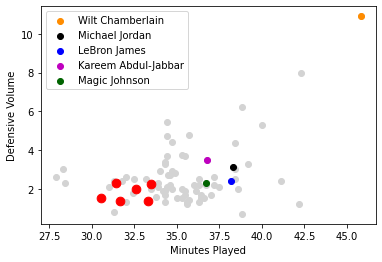

In [32]:
y75 = data75_complete['STL']+data75_complete['BLK']
x75 = data75_complete['MP']
x25 = LegendsUnder25['MP']
y25 = LegendsUnder25['STL']+LegendsUnder25['BLK']

plt.scatter(x75,y75,c='lightgrey')
plt.scatter(x25,y25,s=75,c='red')

for i in range(len(labeled_legends)):
    player = labeled_legends[i]
    curr = data75_complete[data75_complete['Player']==player]
    plt.scatter(curr['MP'], curr['STL']+curr['BLK'], color = colors[i], label = player)
    

#plt.scatter(x75,y75,c='grey')
#plt.scatter(x25,y25,s=75,c='red')
plt.legend(loc = 2)
plt.xlabel('Minutes Played')
plt.ylabel('Defensive Volume')

The figure above plots defensive volume vs minutes played. Defensive volume is calculated as (STL+BLK)

In [33]:
data75.columns

Index(['Player', 'From', 'To', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK',
       'FG%', '3P%', 'FT%', 'WS', 'WS/48'],
      dtype='object')

Text(0, 0.5, 'Efficiency')

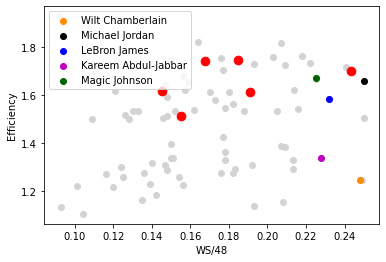

In [34]:
y75 = data75_complete['FG%']+data75_complete['3P%']+data75_complete['FT%']
x75 = data75_complete['WS/48']
x25 = LegendsUnder25['WS/48']
y25 = LegendsUnder25['FG%']+LegendsUnder25['3P%']+LegendsUnder25['FT%']

plt.scatter(x75,y75,c='lightgrey')
plt.scatter(x25,y25,s=75,c='red')

for i in range(len(labeled_legends)):
    player = labeled_legends[i]
    curr = data75_complete[data75_complete['Player']==player]
    plt.scatter(curr['WS/48'], curr['FG%']+curr['3P%']+curr['FT%'], color = colors[i], label = player)
    

#plt.scatter(x75,y75,c='grey')
#plt.scatter(x25,y25,s=75,c='red')
plt.legend(loc = 2)
plt.xlabel('WS/48')
plt.ylabel('Efficiency')

The figure above plots player efficiency vs win shares per 48. Efficiency is calculated as (FG%+3P%+FT%)

Text(0, 0.5, 'Win Shares per 48')

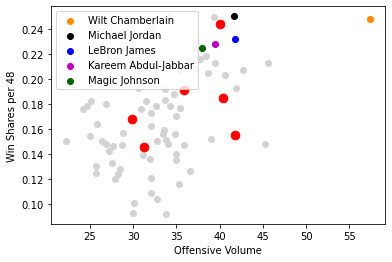

In [35]:
y75 = data75_complete['WS/48']
x75 = data75_complete['PTS']+data75_complete['AST']+data75_complete['TRB']
x25 = LegendsUnder25['PTS']+LegendsUnder25['AST']+LegendsUnder25['TRB']
y25 = LegendsUnder25['WS/48']

plt.scatter(x75,y75,c='lightgrey')
plt.scatter(x25,y25,s=75,c='red')

for i in range(len(labeled_legends)):
    player = labeled_legends[i]
    curr = data75_complete[data75_complete['Player']==player]
    plt.scatter(curr['PTS']+curr['AST']+curr['TRB'], curr['WS/48'], color = colors[i], label = player)
    

#plt.scatter(x75,y75,c='grey')
#plt.scatter(x25,y25,s=75,c='red')
plt.legend(loc = 2)
plt.xlabel('Offensive Volume')
plt.ylabel('Win Shares per 48')

Text(0, 0.5, 'Win Shares per 48')

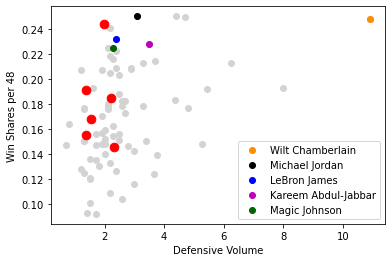

In [36]:
y75 = data75_complete['WS/48']
x75 = data75_complete['STL']+data75_complete['BLK']
x25 = LegendsUnder25['STL']+LegendsUnder25['BLK']
y25 = LegendsUnder25['WS/48']

plt.scatter(x75,y75,c='lightgrey')
plt.scatter(x25,y25,s=75,c='red')

for i in range(len(labeled_legends)):
    player = labeled_legends[i]

    curr = data75_complete[data75_complete['Player']==player]
    plt.scatter(curr['STL']+curr['BLK'], curr['WS/48'], color = colors[i], label = player)
    

#plt.scatter(x75,y75,c='grey')
#plt.scatter(x25,y25,s=75,c='red')
plt.legend(loc = 4)
plt.xlabel('Defensive Volume')
plt.ylabel('Win Shares per 48')

In [37]:
PER = data2021Advanced.copy()
PER['Player'] = PER['Player'].str.replace(r'\\.*', '')
PERPlayers = ['John Collins']
John = PER[PER.Player == 'John Collins']
Luka = PER[PER.Player == 'Luka Don']
Nikola = PER[PER.Player == 'Nikola Joki']
Kristaps = PER[PER.Player == 'Kristaps Porzi']
Karl = PER[PER.Player == 'Karl-Anthony Towns']
PER = PER[PER.Player == 'Zion Williamson']
PER = pd.concat([Nikola, PER, Luka,Karl,Kristaps,John], ignore_index=True)
PER = PER[['Player', 'PER']]
PER.head(10)

,Player,PER
0,Nikola Joki,31.3
1,Zion Williamson,27.1
2,Luka Don,25.3
3,Karl-Anthony Towns,23.1
4,Kristaps Porzi,21.3
5,John Collins,20.6


### Who is the BEST Player

This list of six players answers part of our question, of which players belong with the greats. But we also wanted to get an answer of which one player is best, and which is most likely to be considered the next GOAT.

We used PER (Player Efficiency Rating) to measure this stat, as this shows a rating of a player's per-minute productivity. This is an excellent advanced stat, as it's per-minute and is pace-adjusted, meaning it normalizes lots of factors between players to create a very fair statistic. Because this stat is extremely powerful, we thought it was a very good way to rank players. 